In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [2]:
import pandas as pd
import numpy as np
import paddle
import paddle_quantum
from paddle_quantum.dataset import *
from paddle_quantum.ansatz import Circuit
from numpy import pi as PI
from paddle import matmul, transpose, reshape 
from paddle_quantum.qinfo import pauli_str_to_matrix  
from paddle_quantum.linalg import dagger 
from matplotlib import pyplot as plt
import time

C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\openfermion\hamiltonians\hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


In [3]:
def Observable(n):
    #Z \otimes I \otimes ... \otimes I
    #Observation gate
    Ob = pauli_str_to_matrix([[1.0, 'z0']], n)
    return Ob

In [4]:
class Opt_Classifier(paddle_quantum.gate.Gate):
    
    def __init__(self, n, depth, seed_paras=1):
        super(Opt_Classifier, self).__init__()
        self.n = n
        self.depth = depth
        #Initialize bias
        self.bias = self.create_parameter(
            shape=[1],
            default_initializer=paddle.nn.initializer.Normal(std=0.01),
            dtype='float32',
            is_bias=False)
        
        self.circuit = Circuit(n)
        
        #Create Rz,Ry,Rx gate
        for i in range(n):
            self.circuit.rz(qubits_idx=i)
            self.circuit.ry(qubits_idx=i)
            self.circuit.rz(qubits_idx=i)

        #Add CNOT  
        for d in range(3, depth + 3):
            
            for i in range(n-1):
                self.circuit.cnot(qubits_idx=[i, i + 1])
            self.circuit.cnot(qubits_idx=[n-1, 0])
            
            #Add Ry
            for i in range(n):
                self.circuit.ry(qubits_idx=i)
                
                

    def forward(self, state_in, label):
        
        
        #convert to tensor 
        Ob = paddle.to_tensor(Observable(self.n))
        label_pp = reshape(paddle.to_tensor(label), [-1, 1])

        #Initialize theta
        Utheta = self.circuit.unitary_matrix()

        #Calculate the output state
        state_out = matmul(state_in, Utheta)  
        
        #Calculate the Expectation of <Z> on the first qbit
        #Expectation of <Z> on the first qbit, E = <out|Z \otimes I.....|out>
        E_Z = matmul(matmul(state_out, Ob), transpose(paddle.conj(state_out), perm=[0, 2, 1]))

        
        
        #<Z> is usually in [-1,1], to map the final result between [0,1](a probability)
        #Let pred_y = <Z>/2 + 1/2 + bias (range is [0,1])
        #state_predict = paddle.real(E_Z)[:, 0] * 0.5 + 0.5 + self.bias  
        
        #Sigmoid is range bewteen [0,1], uncomment the following line to try Sigmoid as mapping function
        sd = paddle.nn.Sigmoid()
        state_predict =  sd(paddle.real(E_Z)[:, 0]) +self.bias
        
        #MSE loss
        loss = paddle.mean((state_predict - label_pp) ** 2)  

        #If the value is <0.5 , then label 0. Otherwise label 1.
        #Calculate the accuracy
        is_correct = (paddle.abs(state_predict - label_pp) < 0.5).nonzero().shape[0]
        acc = is_correct / label.shape[0]

        return loss, acc, state_predict.numpy(), self.circuit

In [6]:
#Read train data. Replace Nan value by mean
train_data = pd.read_csv('train.csv')
train_data.fillna(train_data['Age'].mean(),inplace = True)
train_label = train_data['Survived']
train_data = train_data.drop(['Survived','PassengerId'],axis = 1)
#normalize data
normdata=(train_data-train_data.mean())/train_data.std()
trainX = normdata.to_numpy()
trainY = train_label.to_numpy()
trainY = trainY.reshape(-1,1)
train_x = trainX
train_y = trainY

#Read test data
test_data = pd.read_csv('test.csv')
test_data.fillna(test_data['Age'].mean(),inplace = True)
test_data.fillna(test_data['Fare'].mean(),inplace = True)
test_label = test_data['Survived']
test_data = test_data.drop('Survived',axis = 1)
test_data = test_data.drop('PassengerId',axis = 1)
#normalize data
normdata=(test_data-test_data.mean())/test_data.std()
testX = normdata.to_numpy()
testY = test_label.to_numpy()
testY = testY.reshape(-1,1)
test_x = testX
test_y = testY
train_x.shape,train_y.shape

((891, 5), (891, 1))

In [7]:
def QClassifier(quantum_train_x, train_y,quantum_test_x,test_y, N, DEPTH, EPOCH, LR, BATCH):
    
    Ntrain = len(quantum_train_x)
    
    paddle.seed(1)

    net = Opt_Classifier(n=N, depth=DEPTH)

   
    summary_loss, summary_test_acc = [], []

    
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

 
    for ep in range(1,EPOCH+1):
        #Equvlant to dataloader and iteration in NN trainings
        for itr in range(Ntrain // BATCH+1):
            l = itr*BATCH
            r = min( (itr + 1) * BATCH , Ntrain)
            input_state = quantum_train_x[l:r]  
            input_state = reshape(input_state, [-1, 1, 2 ** N])
            label = train_y[l:r]
            test_input_state = reshape(quantum_test_x, [-1, 1, 2 ** N])

            loss, train_acc, state_predict_useless, cir = net(state_in=input_state, label=label)
            loss.backward()
            opt.minimize(loss)
            opt.clear_grad()
        
        #print performance information for each epoch
        loss_useless, test_acc, state_predict_useless, t_cir = net(state_in=test_input_state, label=test_y)
        print("epoch:", ep, 
              "loss: %.4f" % loss.numpy(),
              "train acc: %.4f" % train_acc,
              "test acc: %.4f" % test_acc)
        summary_test_acc.append(test_acc)
        summary_loss.append(loss)
        
    #print the resultant circuit
    print(cir)
    
    
    return summary_test_acc,summary_loss

In [8]:
#5 different encoding methods
encoding_list = ['amplitude_encoding', 'angle_encoding', 'pauli_rotation_encoding', 'IQP_encoding', 'complex_entangled_encoding']

#parameters 
dimension = train_x.shape[1]

import math
#Need n = log2(d) + 1 number of qbit to encode features in dimension d
num_qubit = int(math.log2(train_x.shape[1]))+1

depth = 1
epoch = 2
lr = 0.01
batch_size = 32




acc_list = []
trainloss_list = []
for i in range(len(encoding_list)):
    encoding = encoding_list[i]
    
    print("Encoding method:", encoding)
    #Encoding
    quantum_train_x= SimpleDataset(dimension).encode(train_x, encoding, num_qubit)
    quantum_test_x= SimpleDataset(dimension).encode(test_x, encoding, num_qubit)
    quantum_train_x = paddle.to_tensor(quantum_train_x)
    quantum_test_x = paddle.to_tensor(quantum_test_x)
    
    
    time_start = time.time()
    
    acc,train_ls = QClassifier(
            quantum_train_x, 
            train_y,         
            quantum_test_x,  
            test_y,          
            N = num_qubit,   
            DEPTH = depth,      
            EPOCH = epoch,       
            LR = lr,        
            BATCH = batch_size,      
          )
    time_span = time.time() - time_start
    print(encoding,'time spend is :',time_span, 's')
    print()
    acc_list.append(acc)
    trainloss_list.append(train_ls)

Encoding method: amplitude_encoding


C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\fluid\dyg

epoch: 1 loss: 0.2060 train acc: 0.6667 test acc: 0.5837
epoch: 2 loss: 0.2053 train acc: 0.6667 test acc: 0.5861
--Rz(2.455)----Ry(6.020)----Rz(3.910)----*---------x----Ry(3.896)--
                                         |         |               
--Rz(4.096)----Ry(3.376)----Rz(0.609)----x----*----|----Ry(3.335)--
                                              |    |               
--Rz(2.960)----Ry(5.399)----Rz(2.180)---------x----*----Ry(1.150)--
                                                                   
amplitude_encoding time spend is : 1.033200979232788 s

Encoding method: angle_encoding
epoch: 1 loss: 0.2827 train acc: 0.6296 test acc: 0.6148
epoch: 2 loss: 0.2674 train acc: 0.6296 test acc: 0.6220
--Rz(2.412)----Ry(5.612)----Rz(4.143)----*---------x----Ry(3.468)--
                                         |         |               
--Rz(4.072)----Ry(3.354)----Rz(0.616)----x----*----|----Ry(3.458)--
                                              |    |               
--Rz

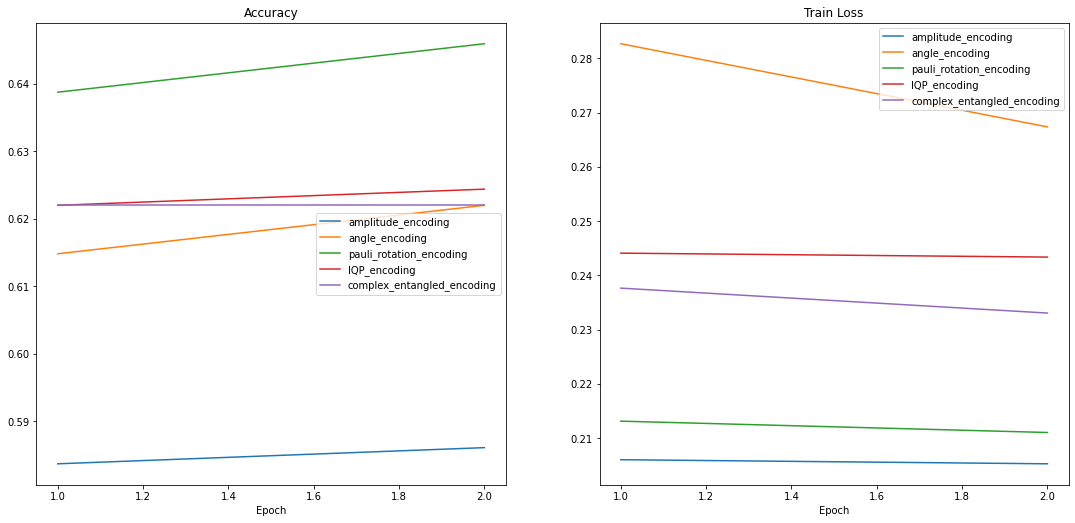

In [9]:
#plot results
x=[i for i in range(1,epoch+1)]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 8.5)
for i in range(len(encoding_list)):
    ax1.plot(x,acc_list[i])
    ax1.set_title("Accuracy")
    ax1.legend(encoding_list)
    ax1.set_xlabel('Epoch')
    
    ax2.plot(x,trainloss_list[i])
    ax2.set_title("Train Loss")
    ax2.legend(encoding_list)
    ax2.set_xlabel('Epoch')

plt.legend(encoding_list)
plt.show()

In [10]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [11]:
train_data = TabularDataset('train.csv')
label = 'Survived'
save_path = 'agModels-predictClass'
predictor = TabularPredictor(label=label, path=save_path).fit(train_data)

Loaded data from: train.csv | Columns = 7 / 7 | Rows = 891 -> 891
Beginning AutoGluon training ...
AutoGluon will save models to "agModels-predictClass\"
AutoGluon Version:  0.7.0
Python Version:     3.9.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    891
Train Data Columns: 6
Label Column: Survived
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9636.44 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inf

In [12]:
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0               XGBoost   0.743017       0.002046  0.389141                0.002046           0.389141            1       True         11
1   WeightedEnsemble_L2   0.743017       0.002046  0.631805                0.000000           0.242664            2       True         14
2            LightGBMXT   0.731844       0.000000  0.259203                0.000000           0.259203            1       True          3
3              LightGBM   0.731844       0.000000  0.300524                0.000000           0.300524            1       True          4
4         LightGBMLarge   0.731844       0.008050  0.782969                0.008050           0.782969            1       True         13
5       NeuralNetFastAI   0.731844       0.010234  1.060650                0.010234           1.060650        

C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\autogluon\core\utils\plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


In [13]:
test_data = TabularDataset('test.csv')
y_test = test_data[label]  
test_data_nolab = test_data.drop(columns=[label])  
y_pred = predictor.predict(test_data_nolab)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Loaded data from: test.csv | Columns = 7 / 7 | Rows = 418 -> 418
Evaluation: accuracy on test data: 0.6650717703349283
Evaluations on test data:
{
    "accuracy": 0.6650717703349283,
    "balanced_accuracy": 0.6488315481986369,
    "mcc": 0.29497546755098064,
    "f1": 0.5679012345679012,
    "precision": 0.5542168674698795,
    "recall": 0.5822784810126582
}


In [14]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI,0.703349,0.731844,0.015625,0.010234,1.060650,0.015625,0.010234,1.060650,1,True,10
1,ExtraTreesGini,0.686603,0.709497,0.062485,0.046868,0.305261,0.062485,0.046868,0.305261,1,True,8
2,ExtraTreesEntr,0.686603,0.715084,0.068998,0.031242,0.354113,0.068998,0.031242,0.354113,1,True,9
3,NeuralNetTorch,0.674641,0.715084,0.000000,0.010109,1.430343,0.000000,0.010109,1.430343,1,True,12
4,RandomForestEntr,0.672249,0.726257,0.068996,0.037746,0.300715,0.068996,0.037746,0.300715,1,True,6
5,LightGBMXT,0.669856,0.731844,0.000000,0.000000,0.259203,0.000000,0.000000,0.259203,1,True,3
6,LightGBMLarge,0.669856,0.731844,0.022130,0.008050,0.782969,0.022130,0.008050,0.782969,1,True,13
7,RandomForestGini,0.669856,0.731844,0.069010,0.031247,0.386772,0.069010,0.031247,0.386772,1,True,5
8,XGBoost,0.665072,0.743017,0.015619,0.002046,0.389141,0.015619,0.002046,0.389141,1,True,11
9,WeightedEnsemble_L2,0.665072,0.743017,0.015619,0.002046,0.631805,0.000000,0.000000,0.242664,2,True,14
